<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Challenge 2 - Part 1 & 2: <strong>Data Preparation & Custom CNN</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>for cats_and_dogs dataset using neural networks</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Aprendizagem Profunda para Visão por Computador 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            color: #333;
            margin: 0;
            padding: 20px;
            line-height: 1.6;
        }
        ol {
            counter-reset: section;
            list-style: none;
            padding-left: 0;
        }
        /* First-level list */
        ol > li {
            counter-increment: section;
            margin-bottom: 10px;
            padding-left: 0;
        }
        ol > li::before {
            content: counters(section, ".") " ";
            font-weight: bold;
        }
        /* Second-level list */
        ol ol {
            counter-reset: subsection;
            padding-left: 20px;
            margin-top: 5px;
        }
        ol ol > li {
            counter-increment: subsection;
            margin-bottom: 5px;
            padding-left: 10px;
        }
        ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) " ";
            font-weight: bold;
        }
        /* Third-level list */
        ol ol ol {
            counter-reset: subsubsection;
            padding-left: 40px;
            margin-top: 5px;
        }
        ol ol ol > li {
            counter-increment: subsubsection;
            margin-bottom: 5px;
            padding-left: 10px;
            font-size: 0.9em; /* Make font size smaller */
            font-weight: normal; /* Remove bold styling */
        }
        ol ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) "." counter(subsubsection) " ";
            font-weight: bold;
        }
        a {
            text-decoration: none;
            color: #007BFF;
            font-weight: bold;
        }
        a:hover {
            color: #0056b3;
        }
        footer {
            margin-top: 50px;
        }
    </style>
</head>
<body>

<h2><b>Índice</b></h2>
<ol>
    <li><a href="#1">Objetivo desta parte</a></li>
    <li><a href="#2">Setup para desenvolvimento do projeto</a></li>
    <li><a href="#3">Classificação multi-classe</a></li>
        <ol>
            <li><a href="#3.1">Obter um conjunto de validação</a></li>
            <li><a href="#3.2">Construir o modelo</a></li>
            <li><a href="#3.3">Compilar a rede</a></li>
            <li><a href="#3.4">Treinar o modelo – max 50 épocas, de pref. a usar callbacks</a></li>
            <li><a href="#3.5">Gráfico que mostre a evolução do treino</a></li>
            <li><a href="#3.6">Cálculo dos acertos no conjunto de teste</a></li>
            <li><a href="#3.7">Mostrar a matriz de confusão</a></li>
        </ol>
    <li><a href="#4">Conversão da Classificação multi-classe para Binária</a></li>
    <li><a href="#5">Model Explanation</a></li>
</ol>

<footer></footer>

</body>
</html>

# <a class='anchor' id='1'></a>

> # **1. Objetivo desta parte** 

Dizer os objetivos

# <a class='anchor' id='2'></a>

> # **2. Setup para desenvolvimento do projeto**

In [1]:
import tensorflow as tf
import keras
from keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import cv2

import seaborn as sns
import sys
import os
from pathlib import Path

import nbformat
from nbconvert import PythonExporter

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore

from tensorflow.keras.models import Model 

In [2]:
# Configurar a seed do TensorFlow
tf.keras.utils.set_random_seed(42)
# Definir a seed global para a operação de GPU
tf.config.experimental.enable_op_determinism()


# Definir o número de threads
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Para evitar log excessivo de TensorFlow
os.environ['OMP_NUM_THREADS'] = '1'  # Para limitar o número de threads

In [3]:
%%capture

# parte 1
# Carregar o notebook
with open("D2Parte1.ipynb") as f:
    notebook = nbformat.read(f, as_version=4)

# Converter para código Python
exporter = PythonExporter()
code, _ = exporter.from_notebook_node(notebook)

# Executar o código no ambiente atual
exec(code);

# <a class='anchor' id='3'></a>

> # **3. Classificação multi-classe**

# <a class='anchor' id='3.2'></a>

> ## **b) Construir o modelo**

In [ ]:
# Baseline model
model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Flatten(),
    layers.GlobalAveragePooling2D(),  # Substituir o Flatten
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

In [5]:
best_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="tmp/baseline.weights.h5",      # ficheiro para os pesos do "melhor modelo"
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

# <a class='anchor' id='3.3'></a>

> ## **c) Compilar a rede**

In [6]:
# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# <a class='anchor' id='3.4'></a>

> ## **d) Treinar o modelo – max 50 épocas, de pref. a usar callbacks**


In [7]:
# Treinar o modelo (máx. 50 épocas, usando callbacks)
history = model.fit(train, epochs=50, 
                    validation_data=validation,
                    callbacks=[best_model_checkpoint, early_stopping])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.4810 - loss: 2.5006 - precision: 0.4764 - recall: 0.5007 - val_accuracy: 0.5640 - val_loss: 0.6775 - val_precision: 0.5358 - val_recall: 0.8785
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5462 - loss: 0.6889 - precision: 0.5470 - recall: 0.5706 - val_accuracy: 0.4880 - val_loss: 0.6793 - val_precision: 0.4908 - val_recall: 0.9676
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5550 - loss: 0.6861 - precision: 0.5483 - recall: 0.6466 - val_accuracy: 0.4940 - val_loss: 0.6849 - val_precision: 0.4937 - val_recall: 0.9555
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5622 - loss: 0.6772 - precision: 0.5507 - recall: 0.7067 - val_accuracy: 0.6120 - val_loss: 0.6551 - val_precision: 0.6082 - val_recall: 0.6032
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5702 - loss: 0.6627 - precision: 0.5732 - recall: 0.5725 - val_accuracy: 0.6140 - val_loss: 0.6720 

# <a class='anchor' id='3.5'></a>

> ## **e) Gráfico que mostre a evolução do treino**

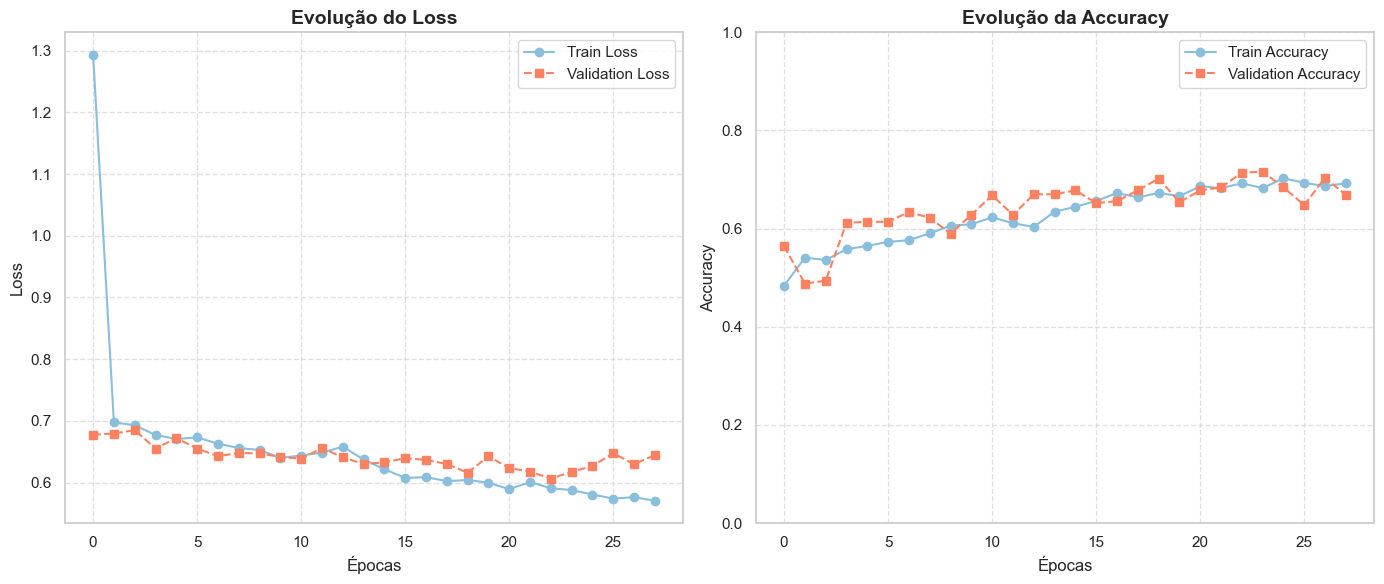

In [8]:
# Configurar o estilo do seaborn
sns.set(style="whitegrid", palette="muted")

# Criar a figura
plt.figure(figsize=(14, 6))

# Subplot para Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color=sns.color_palette("Blues")[2], linestyle='-', marker='o', markersize=6)
plt.plot(history.history['val_loss'], label='Validation Loss', color=sns.color_palette("Reds")[2], linestyle='--', marker='s', markersize=6)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot para Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color=sns.color_palette("Blues")[2], linestyle='-', marker='o', markersize=6)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=sns.color_palette("Reds")[2], linestyle='--', marker='s', markersize=6)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evolução da Accuracy', fontsize=14, fontweight='bold')
plt.ylim(0, 1)  # Garantir que o eixo Y da Accuracy vai de 0 a 1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar espaçamento
plt.tight_layout()
plt.show()


In [9]:
# Carregar melhor modelo em validação
model.load_weights("tmp/baseline.weights.h5")

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,405 (384.40 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,604 (256.27 KB)

# <a class='anchor' id='3.6'></a>

> ## **f) Cálculo dos acertos no conjunto de teste**

In [11]:
train_list = list(train)
first_batch_x, first_batch_y = train_list[0]

In [12]:
len(train_labels)

2000

In [13]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test, verbose=0)[:2]
num_acertos = int(test_acc * len(train_labels))
print(f'Accuracy no conjunto de teste: {test_acc:.4f}')
print(f'Número absoluto de acertos: {num_acertos}/{len(train_labels)}')

Accuracy no conjunto de teste: 0.6680
Número absoluto de acertos: 1335/2000


# <a class='anchor' id='3.7'></a>

> ## **g) Mostrar a matriz de confusão**

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


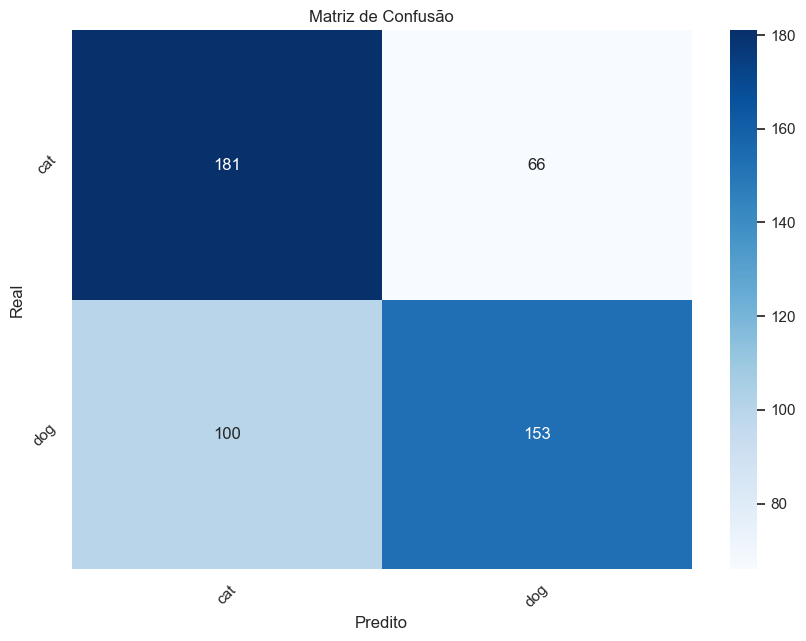

In [14]:
# Predições e matriz de confusão
y_pred = model.predict(test)
y_pred_classes = y_pred.squeeze()>0.5
y_true_classes = test_labels.squeeze()

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [15]:
# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

Relatório de Classificação:
              precision    recall  f1-score   support

         cat       0.64      0.73      0.69       247
         dog       0.70      0.60      0.65       253

    accuracy                           0.67       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.67      0.67      0.67       500



# <a class='anchor' id='5'></a>

> # **5. Model Explanation**

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,405 (384.40 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,604 (256.27 KB)

In [17]:
linear_model = tf.keras.models.Model(inputs=[model.layers[0].input], outputs=[model.layers[-2].output])

In [18]:
train_preds = model.predict(train).squeeze()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [19]:
labels

['cat', 'dog']

In [20]:
train_list = list(train)
score = CategoricalScore([0])
saliency = Saliency(model, clone=False)

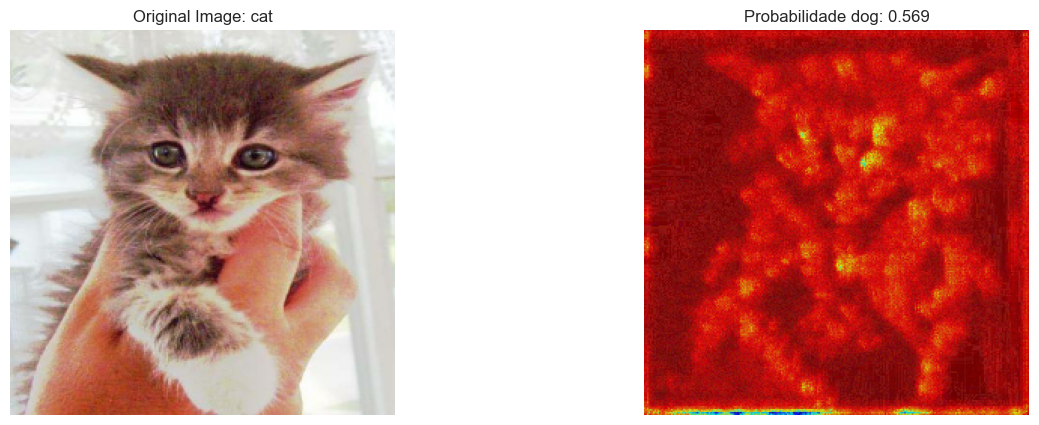

In [21]:
# Load and preprocess an example image
img_id = 0 # 5656
img = train_list[0][0][img_id]  # Tensor
img_array = np.expand_dims(img, axis=0)  # Normalize and add batch dimension, now numpy array

# Compute saliency map
saliency_map = saliency(score, img_array, smooth_samples=30, smooth_noise=0.1)
saliency_map = normalize(saliency_map)

# Overlay saliency map on original image with higher transparency for saliency
heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map).squeeze(), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(heatmap, 0.8, np.uint8(255 * img), .1, 0)  # Adjust transparency here

# Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img.numpy().astype("uint8"))
ax[0].set_title(f"Original Image: {labels[int(train_list[0][1][img_id])]}")  # Show label
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title(f"Probabilidade {labels[1]}: {train_preds[img_id]:.3f}")
ax[1].axis("off")

plt.show()

In [22]:
# https://tree.rocks/get-heatmap-from-cnn-convolution-neural-network-aka-grad-cam-222e08f57a34